<a href="https://colab.research.google.com/github/zubair2004/Continuing-Common-Sequences/blob/main/MATS(continuing_common_sequences).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Modules and Model**

In [1]:
import sys, os
%pip install transformer-lens==2.0.0
%pip install torch==2.3.1
!apt install -y graphviz
!apt install libgraphviz-dev
%pip install pygraphviz
%pip install cmapy
!git clone https://github.com/hannamw/EAP-positional.git
%cd EAP-positional
!git checkout tutorial
%pip install -e .
sys.path.append(os.getcwd())
%cd ..

!pip install tqdm==4.66.4
!pip install datasets==2.20.0
!pip install jaxtyping==0.2.31
!pip install better_abc==0.0.3
!pip install fancy_einsum==0.0.3
!pip install wandb==0.17.4
!pip install einops==0.8.0
!pip install tokenizers==0.19.1
!pip install pyarrow==16.1.0
!pip install datasets==2.20.0
!pip install transformers == 4.42.3
!pip install huggingface_hub == 0.23.4
!apt-get install git-lfs

%pip install torchtyping
# Install my janky personal plotting utils
%pip install git+https://github.com/neelnanda-io/neel-plotly.git
# Install another version of node that makes PySvelte work way faster
%pip install circuitsvis
# Needed for PySvelte to work, v3 came out and broke things...
%pip install typeguard==2.13.3

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from typing import List, Union, Optional, Tuple, Literal, Callable
from functools import partial
from IPython.display import Image, display
from torchtyping import TensorType as TT
import copy
import itertools
import json

import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
from torch.utils.data import DataLoader

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import (
    HookedTransformer,
    HookedTransformerConfig,
    FactoredMatrix,
    ActivationCache,
)
import plotly.io as pio

from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML, Markdown
from pprint import pprint

from neel_plotly import line, imshow, scatter
import transformer_lens.patching as patching

pio.renderers.default = "colab"

device = "cuda" if torch.cuda.is_available() else "cpu"
if not torch.cuda.is_available():
    print("WARNING: Running on CPU. Did you remember to set your Colab accelerator to GPU?")


In [3]:
model_name = 'gpt2-small'
model = HookedTransformer.from_pretrained(model_name, device=device)
model.set_use_attn_result(True)
model.cfg.use_attn_in = True
model.cfg.use_split_qkv_input = True
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


# **Reading and Modifying Dataset**

In [4]:
!wget https://raw.githubusercontent.com/zubair2004/Continuing-Common-Sequences/main/continuing_common_sequences.csv

--2024-08-26 16:16:44--  https://raw.githubusercontent.com/zubair2004/Continuing-Common-Sequences/main/continuing_common_sequences.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939 [text/plain]
Saving to: ‘continuing_common_sequences.csv’

continuing_common_s 100%[===================>]     939  --.-KB/s    in 0s      

2024-08-26 16:16:44 (21.9 MB/s) - ‘continuing_common_sequences.csv’ saved [939/939]



In [5]:
s = "1,2,3,4,"
logits=model(s).squeeze(0).cpu()
probs = torch.softmax(logits, dim=-1)
probs, next_tokens = torch.topk(probs[-1], 10)
for prob, token_id in zip(probs, next_tokens):
  token = model.tokenizer.decode(token_id.item())
  print(f"{token.strip()}\t{prob.item():.3f}")
print(f"The token length of the sentence is {len(logits)}")

5	0.924
6	0.014
4	0.007
1	0.007
7	0.006
3	0.002
9	0.002
8	0.002
2	0.002
0	0.002
The token length of the sentence is 9


In [6]:
df = pd.read_csv('continuing_common_sequences.csv')
print(df.iloc[0])

clean          1,2,3,4,
corrupted      1,1,1,1,
target                5
corr_target           1
Name: 0, dtype: object


In [7]:
def batch_dataset(df, batch_size=1):
    clean, corrupted, target = [df[col].tolist() for col in ['clean', 'corrupted', 'target']]
    clean = [clean[i:i+batch_size] for i in range(0, len(df), batch_size)]
    corrupted = [corrupted[i:i+batch_size] for i in range(0, len(df), batch_size)]
    target = [target[i:i+batch_size] for i in range(0, len(df), batch_size)]
    return [(clean[i], corrupted[i], target[i]) for i in range(len(clean))]

dataset = batch_dataset(df, batch_size=1)
print(dataset[0])

(['1,2,3,4,'], ['1,1,1,1,'], ['5'])


# **Evaluation funtions for circuit Finding**

In [8]:
import eap

## **Graph module**

In [9]:
from typing import List, Dict, Union, Tuple, Literal, Optional, Set
from collections import defaultdict
from pathlib import Path
import heapq

import pygraphviz as pgv

from eap.visualization import EDGE_TYPE_COLORS, generate_random_color

class Node:
    """
    A node in our computational graph. The in_hook is the TL hook into its inputs,
    while the out_hook gets its outputs.
    """
    name: str
    layer: int
    in_hook: str
    out_hook: str
    index: Tuple
    parents: Set['Node']
    parent_edges: Set['Edge']
    children: Set['Node']
    child_edges: Set['Edge']
    in_graph: bool
    qkv_inputs: Optional[List[str]]

    def __init__(self, name: str, layer:int, in_hook: List[str], out_hook: str, index: Tuple, qkv_inputs: Optional[List[str]]=None):
        self.name = name
        self.layer = layer
        self.in_hook = in_hook
        self.out_hook = out_hook
        self.index = index
        self.in_graph = True
        self.parents = set()
        self.children = set()
        self.parent_edges = set()
        self.child_edges = set()
        self.qkv_inputs = qkv_inputs

    def __eq__(self, other):
        return self.name == other.name

    def __repr__(self):
        return f'Node({self.name})'

    def __hash__(self):
        return hash(self.name)

class LogitNode(Node):
    def __init__(self, n_layers:int):
        name = 'logits'
        index = slice(None)
        super().__init__(name, n_layers - 1, f"blocks.{n_layers - 1}.hook_resid_post", '', index)

class MLPNode(Node):
    def __init__(self, layer: int):
        name = f'm{layer}'
        index = slice(None)
        super().__init__(name, layer, f"blocks.{layer}.hook_mlp_in", f"blocks.{layer}.hook_mlp_out", index)

class AttentionNode(Node):
    head: int
    def __init__(self, layer:int, head:int):
        name = f'a{layer}.h{head}'
        self.head = head
        index = (slice(None), slice(None), head)
        super().__init__(name, layer, f'blocks.{layer}.hook_attn_in', f"blocks.{layer}.attn.hook_result", index, [f'blocks.{layer}.hook_{letter}_input' for letter in 'qkv'])

class InputNode(Node):
    def __init__(self):
        name = 'input'
        index = slice(None)
        super().__init__(name, 0, '', "blocks.0.hook_resid_pre", index)

class Edge:
    name: str
    parent: Node
    child: Node
    hook: str
    index: Tuple
    score : Optional[float]
    in_graph: bool
    def __init__(self, parent: Node, child: Node, qkv:Union[None, Literal['q'], Literal['k'], Literal['v']]=None):
        self.name = f'{parent.name}->{child.name}' if qkv is None else f'{parent.name}->{child.name}<{qkv}>'
        self.parent = parent
        self.child = child
        self.qkv = qkv
        self.score = None
        self.in_graph = True
        if isinstance(child, AttentionNode):
            if qkv is None:
                raise ValueError(f'Edge({self.name}): Edges to attention heads must have a non-none value for qkv.')
            self.hook = f'blocks.{child.layer}.hook_{qkv}_input'
            self.index = (slice(None), slice(None), child.head)
        else:
            self.index = child.index
            self.hook = child.in_hook
    def get_color(self):
        if self.qkv is not None:
            return EDGE_TYPE_COLORS[self.qkv]
        elif self.score < 0:
            return "#FF00FF"
        else:
            return "#000000"

    def __eq__(self, other):
        return self.name == other.name

    def __repr__(self):
        return f'Edge({self.name})'

    def __hash__(self):
        return hash(self.name)

class Graph:
    nodes: Dict[str, Node]
    edges: Dict[str, Edge]
    n_forward: int
    n_backward: int
    cfg: HookedTransformerConfig

    def __init__(self):
        self.nodes = {}
        self.edges = {}
        self.n_forward = 0
        self.n_backward = 0

    def add_edge(self, parent:Node, child:Node, qkv:Union[None, Literal['q'], Literal['k'], Literal['v']]=None):
        edge = Edge(parent, child, qkv)
        self.edges[edge.name] = edge
        parent.children.add(child)
        parent.child_edges.add(edge)
        child.parents.add(parent)
        child.parent_edges.add(edge)

    def forward_index(self, node:Node, attn_slice=True):
        if isinstance(node, InputNode):
            return 0
        elif isinstance(node, LogitNode):
            return self.n_forward
            # raise ValueError(f"No forward for logits node")
        elif isinstance(node, MLPNode):
            return 1 + node.layer * (self.cfg['n_heads'] + 1) + self.cfg['n_heads']
        elif isinstance(node, AttentionNode):
            i =  1 + node.layer * (self.cfg['n_heads'] + 1)
            return slice(i, i + self.cfg['n_heads']) if attn_slice else i + node.head
        else:
            raise ValueError(f"Invalid node: {node} of type {type(node)}")


    def backward_index(self, node:Node, qkv=None, attn_slice=True):
        if isinstance(node, InputNode):
            raise ValueError(f"No backward for input node")
        elif isinstance(node, LogitNode):
            return -1
        elif isinstance(node, MLPNode):
            return (node.layer) * (3 * self.cfg['n_heads'] + 1) + 3 * self.cfg['n_heads']
        elif isinstance(node, AttentionNode):
            assert qkv in 'qkv', f'Must give qkv for AttentionNode, but got {qkv}'
            i = node.layer * (3 * self.cfg['n_heads'] + 1) + ('qkv'.index(qkv) * self.cfg['n_heads'])
            return slice(i, i + self.cfg['n_heads']) if attn_slice else i + node.head
        else:
            raise ValueError(f"Invalid node: {node} of type {type(node)}")

    def scores(self, absolute=False, nonzero=False, in_graph=False, sort=True):
        s = [edge.score for edge in self.edges.values() if edge.score != 0 and (edge.in_graph or not in_graph)] if nonzero else [edge.score for edge in self.edges.values()]
        s = torch.tensor(s)
        if absolute:
            s = s.abs()
        return torch.sort(s).values if sort else s

    def count_included_edges(self):
        return sum(edge.in_graph for edge in self.edges.values())

    def count_included_nodes(self):
        return sum(node.in_graph for node in self.nodes.values())

    def apply_threshold(self, threshold: float, absolute: bool):
        threshold = float(threshold)
        for node in self.nodes.values():
            node.in_graph = True

        for edge in self.edges.values():
            edge.in_graph = abs(edge.score) >= threshold if absolute else edge.score >= threshold

    def apply_greedy(self, n_edges, reset=True, absolute: bool=False):
        if reset:
            for node in self.nodes.values():
                node.in_graph = False
            for edge in self.edges.values():
                edge.in_graph = False
            self.nodes['logits'].in_graph = True

        def abs_id(s: float):
            return abs(s) if absolute else s

        candidate_edges = sorted([edge for edge in self.edges.values() if edge.child.in_graph], key = lambda edge: abs_id(edge.score), reverse=True)

        edges = heapq.merge(candidate_edges, key = lambda edge: abs_id(edge.score), reverse=True)
        while n_edges > 0:
            n_edges -= 1
            top_edge = next(edges)
            top_edge.in_graph = True
            parent = top_edge.parent
            if not parent.in_graph:
                parent.in_graph = True
                parent_parent_edges = sorted([parent_edge for parent_edge in parent.parent_edges], key = lambda edge: abs_id(edge.score), reverse=True)
                edges = heapq.merge(edges, parent_parent_edges, key = lambda edge: abs_id(edge.score), reverse=True)

    def prune_dead_nodes(self, prune_childless=True, prune_parentless=True):
        self.nodes['logits'].in_graph = any(parent_edge.in_graph for parent_edge in self.nodes['logits'].parent_edges)

        for node in reversed(self.nodes.values()):
            if isinstance(node, LogitNode):
                continue

            if any(child_edge.in_graph for child_edge in node.child_edges) :
                node.in_graph = True
            else:
                if prune_childless:
                    node.in_graph = False
                    for parent_edge in node.parent_edges:
                        parent_edge.in_graph = False
                else:
                    if any(child_edge.in_graph for child_edge in node.child_edges):
                        node.in_graph = True
                    else:
                        node.in_graph = False

        if prune_parentless:
            for node in self.nodes.values():
                if not isinstance(node, InputNode) and node.in_graph and not any(parent_edge.in_graph for parent_edge in node.parent_edges):
                    node.in_graph = False
                    for child_edge in node.child_edges:
                        child_edge.in_graph = False


    @classmethod
    def from_model(cls, model_or_config: Union[HookedTransformer,HookedTransformerConfig, Dict]):
        graph = Graph()
        if isinstance(model_or_config, HookedTransformer):
            cfg = model_or_config.cfg
            graph.cfg = {'n_layers': cfg.n_layers, 'n_heads': cfg.n_heads, 'parallel_attn_mlp':cfg.parallel_attn_mlp}
        elif isinstance(model_or_config, HookedTransformerConfig):
            cfg = model_or_config
            graph.cfg = {'n_layers': cfg.n_layers, 'n_heads': cfg.n_heads, 'parallel_attn_mlp':cfg.parallel_attn_mlp}
        else:
            graph.cfg = model_or_config

        input_node = InputNode()
        graph.nodes[input_node.name] = input_node
        residual_stream = [input_node]

        for layer in range(graph.cfg['n_layers']):
            attn_nodes = [AttentionNode(layer, head) for head in range(graph.cfg['n_heads'])]
            mlp_node = MLPNode(layer)

            for attn_node in attn_nodes:
                graph.nodes[attn_node.name] = attn_node
            graph.nodes[mlp_node.name] = mlp_node

            if graph.cfg['parallel_attn_mlp']:
                for node in residual_stream:
                    for attn_node in attn_nodes:
                        for letter in 'qkv':
                            graph.add_edge(node, attn_node, qkv=letter)
                    graph.add_edge(node, mlp_node)

                residual_stream += attn_nodes
                residual_stream.append(mlp_node)

            else:
                for node in residual_stream:
                    for attn_node in attn_nodes:
                        for letter in 'qkv':
                            graph.add_edge(node, attn_node, qkv=letter)
                residual_stream += attn_nodes

                for node in residual_stream:
                    graph.add_edge(node, mlp_node)
                residual_stream.append(mlp_node)

        logit_node = LogitNode(graph.cfg['n_layers'])
        for node in residual_stream:
            graph.add_edge(node, logit_node)

        graph.nodes[logit_node.name] = logit_node

        graph.n_forward = 1 + graph.cfg['n_layers'] * (graph.cfg['n_heads'] + 1)
        graph.n_backward = graph.cfg['n_layers'] * (3 * graph.cfg['n_heads'] + 1) + 1

        return graph


    def to_json(self, filename):
        # non serializable info
        d = {'cfg':self.cfg, 'nodes': {str(name): bool(node.in_graph) for name, node in self.nodes.items()}, 'edges':{str(name): {'score': float(edge.score), 'in_graph': bool(edge.in_graph)} for name, edge in self.edges.items()}}
        with open(filename, 'w') as f:
            json.dump(d, f)

    @classmethod
    def from_json(cls, filename):
        with open(filename, 'r') as f:
            d = json.load(f)
        g = Graph.from_model(d['cfg'])
        for name, in_graph in d['nodes'].items():
            g.nodes[name].in_graph = in_graph

        for name, info in d['edges'].items():
            g.edges[name].score = info['score']
            g.edges[name].in_graph = info['in_graph']

        return g

    def __eq__(self, other):
        keys_equal = (set(self.nodes.keys()) == set(other.nodes.keys())) and (set(self.edges.keys()) == set(other.edges.keys()))
        if not keys_equal:
            return False

        for name, node in self.nodes.items():
            if node.in_graph != other.nodes[name].in_graph:
                return False

        for name, edge in self.edges.items():
            if (edge.in_graph != other.edges[name].in_graph) or not np.allclose(edge.score, other.edges[name].score):
                return False
        return True

    def to_graphviz(
        self,
        colorscheme: str = "Pastel2",
        minimum_penwidth: float = 0.3,
        layout: str="dot",
        seed: Optional[int] = None
    ) -> pgv.AGraph:
        """
        Colorscheme: a cmap colorscheme
        """
        g = pgv.AGraph(directed=True, bgcolor="white", overlap="false", splines="true", layout=layout)

        if seed is not None:
            np.random.seed(seed)

        colors = {node.name: generate_random_color(colorscheme) for node in self.nodes.values()}

        for node in self.nodes.values():
            if node.in_graph:
                g.add_node(node.name,
                        fillcolor=colors[node.name],
                        color="black",
                        style="filled, rounded",
                        shape="box",
                        fontname="Helvetica",
                        )

        for edge in self.edges.values():
            if edge.in_graph:
                score = 0 if edge.score is None else edge.score
                g.add_edge(edge.parent.name,
                        edge.child.name,
                        penwidth=str(max(minimum_penwidth, score) * 2),
                        color=edge.get_color(),
                        )
        return g


## **Rest of the functions**

In [10]:
g = Graph.from_model(model)

In [11]:
print(list(g.nodes.items())[:10])
print(list(g.edges.items())[:10])

[('input', Node(input)), ('a0.h0', Node(a0.h0)), ('a0.h1', Node(a0.h1)), ('a0.h2', Node(a0.h2)), ('a0.h3', Node(a0.h3)), ('a0.h4', Node(a0.h4)), ('a0.h5', Node(a0.h5)), ('a0.h6', Node(a0.h6)), ('a0.h7', Node(a0.h7)), ('a0.h8', Node(a0.h8))]
[('input->a0.h0<q>', Edge(input->a0.h0<q>)), ('input->a0.h0<k>', Edge(input->a0.h0<k>)), ('input->a0.h0<v>', Edge(input->a0.h0<v>)), ('input->a0.h1<q>', Edge(input->a0.h1<q>)), ('input->a0.h1<k>', Edge(input->a0.h1<k>)), ('input->a0.h1<v>', Edge(input->a0.h1<v>)), ('input->a0.h2<q>', Edge(input->a0.h2<q>)), ('input->a0.h2<k>', Edge(input->a0.h2<k>)), ('input->a0.h2<v>', Edge(input->a0.h2<v>)), ('input->a0.h3<q>', Edge(input->a0.h3<q>))]


In [12]:
print(f'Total No. of Nodes in Model: {len(list(g.nodes.items())[:])}')
print(f'Total No. of edges in Model: {len(list(g.edges.items())[:])}')

Total No. of Nodes in Model: 158
Total No. of edges in Model: 32491


In [13]:
def prob_diff(target, logits: torch.Tensor, loss=False, mean=False):
    correct_probs = torch.tensor(0, dtype=torch.float32, device='cuda')
    incorrect_probs = torch.tensor(0, dtype=torch.float32, device='cuda')
    k=10
    probs = torch.softmax(logits[:,-1], dim=-1)
    probs, next_tokens = torch.topk(probs[-1], k)
    results = []
    for i, (prob, token_id) in enumerate(zip(probs,next_tokens)):
        token = model.tokenizer.decode(token_id.item())
        if token==target[0]:
          correct_probs += prob.sum()
        else:
          incorrect_probs += prob.sum()
    results.append(correct_probs - incorrect_probs)

    results = torch.stack(results)
    if loss:
        results = -results
    if mean:
        results = results.mean()
    return results

metric = prob_diff

In [14]:
def evaluate_baseline(model: HookedTransformer, dataset, metrics: List[Callable[[Tensor], Tensor]]):
    metrics_list = True
    if not isinstance(metrics, list):
        metrics = [metrics]
        metrics_list = False

    results = [[] for _ in metrics]
    for clean, corrupted, target in tqdm(dataset):
        with torch.inference_mode():
            logits = model(clean[0])
        for j, metric in enumerate(metrics):
            r = metric(target, logits).cuda()
            if len(r.size()) == 0:
                r = r.unsqueeze(0)
            results[j].append(r)
    results = [torch.cat(rs) for rs in results]
    if not metrics_list:
        results = results[0]
    return results

In [15]:
def evaluate_graph(model: HookedTransformer, graph: Graph, dataset, metrics: List[Callable[[Tensor], Tensor]], prune:bool=True):
    """
    Evaluate a circuit (i.e. a graph where only some nodes are false, probably created by calling graph.apply_threshold). You probably want to prune beforehand to make sure your circuit is valid.
    """
    # Pruning the Graph: If prune is True, it prunes the graph by removing childless and parentless nodes.
    if prune:
        graph.prune_dead_nodes(prune_childless=True, prune_parentless=True)

    # Check for Empty Circuit: Sets empty_circuit to True if the 'logits' node is not in the graph.
    empty_circuit = not graph.nodes['logits'].in_graph

    # Forward Hook Names: Collects the output hooks of parent nodes from all edges in the graph.
    # Forward Filter: Creates a filter function to check if a given hook name is in fwd_names.
    fwd_names = {edge.parent.out_hook for edge in graph.edges.values()}
    fwd_filter = lambda x: x in fwd_names

    # Get Caching Hooks: Retrieves the corrupted and mixed forward caches and hooks from the model using the forward filter.
    corrupted_fwd_cache, corrupted_fwd_hooks, _ = model.get_caching_hooks(fwd_filter)
    mixed_fwd_cache, mixed_fwd_hooks, _ = model.get_caching_hooks(fwd_filter)

    # Nodes in Graph: Collects all nodes in the graph that are not of type InputNode and are part of the graph (in_graph is True).
    nodes_in_graph = [node for node in graph.nodes.values() if node.in_graph if not isinstance(node, InputNode)]

    """For each node in the graph, construct its input (in the case of attention heads, multiple inputs) by corrupting the incoming edges that are not in the circuit.
       We assume that the corrupted cache is filled with corresponding corrupted activations, and that the mixed cache contains the computed activations from preceding nodes in this forward pass."""
    # Input Construction Hook: Defines a nested function make_input_construction_hook that creates an input_construction_hook.
    # Inner Function input_construction_hook: Iterates over the parent edges of a node.
    # If the qkv attribute of an edge does not match the provided qkv parameter, it skips the edge.
    # If the edge is not part of the graph (in_graph is False), it modifies the activations by replacing values from the mixed forward cache with those from the corrupted forward cache.
    # Return: Returns the input_construction_hook function.
    def make_input_construction_hook(node: Node, qkv=None):
        def input_construction_hook(activations, hook):
            for edge in node.parent_edges:
                if edge.qkv != qkv:
                    continue

                parent:Node = edge.parent
                if not edge.in_graph:
                    activations[edge.index] -= mixed_fwd_cache[parent.out_hook][parent.index]
                    activations[edge.index] += corrupted_fwd_cache[parent.out_hook][parent.index]
            return activations
        return input_construction_hook

    # Create Input Construction Hooks: Iterates over the nodes in the graph to create input construction hooks.
    # InputNode: Skips if the node is an InputNode.
    # LogitNode or MLPNode: Adds a hook using make_input_construction_hook without qkv.
    # AttentionNode: Adds hooks for each of 'q', 'k', and 'v' inputs.
    # Invalid Node: Raises an error if the node type is not recognized.
    input_construction_hooks = []
    for node in nodes_in_graph:
        if isinstance(node, InputNode):
            pass
        elif isinstance(node, LogitNode) or isinstance(node, MLPNode):
            input_construction_hooks.append((node.in_hook, make_input_construction_hook(node)))
        elif isinstance(node, AttentionNode):
            for i, letter in enumerate('qkv'):
                input_construction_hooks.append((node.qkv_inputs[i], make_input_construction_hook(node, qkv=letter)))
        else:
            raise ValueError(f"Invalid node: {node} of type {type(node)}")

    # and here we actually run / evaluate the model
    metrics_list = True
    if not isinstance(metrics, list):
        metrics = [metrics]
        metrics_list = False
    results = [[] for _ in metrics]

    for clean, corrupted, target in tqdm(dataset):
        sens = [clean[0], corrupted[0]]
        sens = [str(s) for s in sens]
        max_length = max(len(model.tokenizer.tokenize(s)) for s in sens)
        padded_sentences = [model.tokenizer.encode(s, padding='max_length', max_length=max_length, return_tensors='pt', add_special_tokens=True) for s in sens]
        s1 = padded_sentences[0]
        s2 = padded_sentences[1]
        clean_dash = model.tokenizer.decode(s1[0])
        corrupted_dash = model.tokenizer.decode(s2[0])

        with torch.inference_mode():
            with model.hooks(corrupted_fwd_hooks):
                corrupted_logits = model(corrupted_dash)

            with model.hooks(mixed_fwd_hooks + input_construction_hooks):
                if empty_circuit:
                    # if the circuit is totally empty, so is nodes_in_graph
                    # so we just corrupt everything manually like this
                    logits = model(corrupted_dash)
                else:
                    logits = model(clean_dash)
        for i, metric in enumerate(metrics):
            r = metric(target,logits).cuda()
            if len(r.size()) == 0:
                r = r.unsqueeze(0)
            results[i].append(r)

    results = [torch.cat(rs) for rs in results]
    if not metrics_list:
        results = results[0]
    return results

# **Baseline Scoring**

In [16]:
baseline = evaluate_baseline(model, dataset, metric).mean()
print((f"\n Baseline performance of the dataset: {baseline}"))

TypeError: 'module' object is not callable

In [ ]:
graph_baseline = evaluate_graph(model, g, dataset, metric).mean()
print((f"\n Graph_Baseline performance for the dataset: {graph_baseline}"))

TypeError: 'module' object is not callable

# **Manual Circuit Analysis for whole Dataset**

In [ ]:
source = 'm10'
target = 'logits'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric = evaluate_graph(model, g, dataset, metric).mean()
g.edges[edge_name].in_graph = True
print("\n")
print(f"The difference between the patched metric and baseline is: {patched_metric - baseline }")

100%|██████████| 24/24 [00:02<00:00,  9.13it/s]



The difference between the patched metric and baseline is: -0.06540848314762115


In [ ]:
source = 'a9.h1'
target = 'm9'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric = evaluate_graph(model, g, dataset, metric).mean()
g.edges[edge_name].in_graph = True
print("\n")
print(f"The difference between the patched metric and baseline is: {patched_metric - baseline}")

100%|██████████| 24/24 [00:02<00:00,  8.84it/s]



The difference between the patched metric and baseline is: -0.020703613758087158


In [ ]:
g_manual = Graph.from_model(model)
for edge in g_manual.edges.values():
    edge.in_graph=False

input_node = g_manual.nodes['input']
low_attn = ['a0.h3', 'a0.h5']
low_mlps = ['a0.h1', 'm0', 'm1', 'm2', 'm3']
mid_attn = ['a5.h1', 'a5.h5','a6.h1','a6.h9', 'a7.h10', 'a8.h8', 'a8.h11', 'a9.h1']
high_mlps = [f'm{i}' for i in range(8,12)]
logit_node = g_manual.nodes['logits']

for node in low_attn + low_mlps:
    if f'input->{node}' in g_manual.edges:
        g_manual.edges[f'input->{node}'].in_graph = True
    else:
        for letter in 'qkv':
            g_manual.edges[f'input->{node}<{letter}>'].in_graph = True

    for node2 in mid_attn:
        for letter in 'qkv':
            g_manual.edges[f'{node}->{node2}<{letter}>'].in_graph = True

for i, node in enumerate(low_mlps):
    for node2 in low_mlps[i+1:]:
        g_manual.edges[f'{node}->{node2}'].in_graph = True

for node in mid_attn:
    g_manual.edges[f'{node}->logits'].in_graph=True
    for node2 in high_mlps:
        edge_str = f'{node}->{node2}'
        if edge_str in g_manual.edges:
            g_manual.edges[edge_str].in_graph=True

for i, node in enumerate(high_mlps):
    g_manual.edges[f'{node}->logits'].in_graph=True
    for node2 in high_mlps[i+1:]:
        g_manual.edges[f'{node}->{node2}'].in_graph = True
g_manual.prune_dead_nodes(prune_childless=True, prune_parentless=True)
results = evaluate_graph(model, g_manual, dataset, metric).mean()
print("\n")
print(f"baseline performance: {baseline}. circuit performance: {results}")

100%|██████████| 24/24 [00:05<00:00,  4.48it/s]



baseline performance: -0.1594623178243637. circuit performance: -0.6160374283790588


In [ ]:
print(f"The difference between the circuit and baseline performances is: {results - baseline}")

The difference between the circuit and baseline performances is: -0.45657509565353394


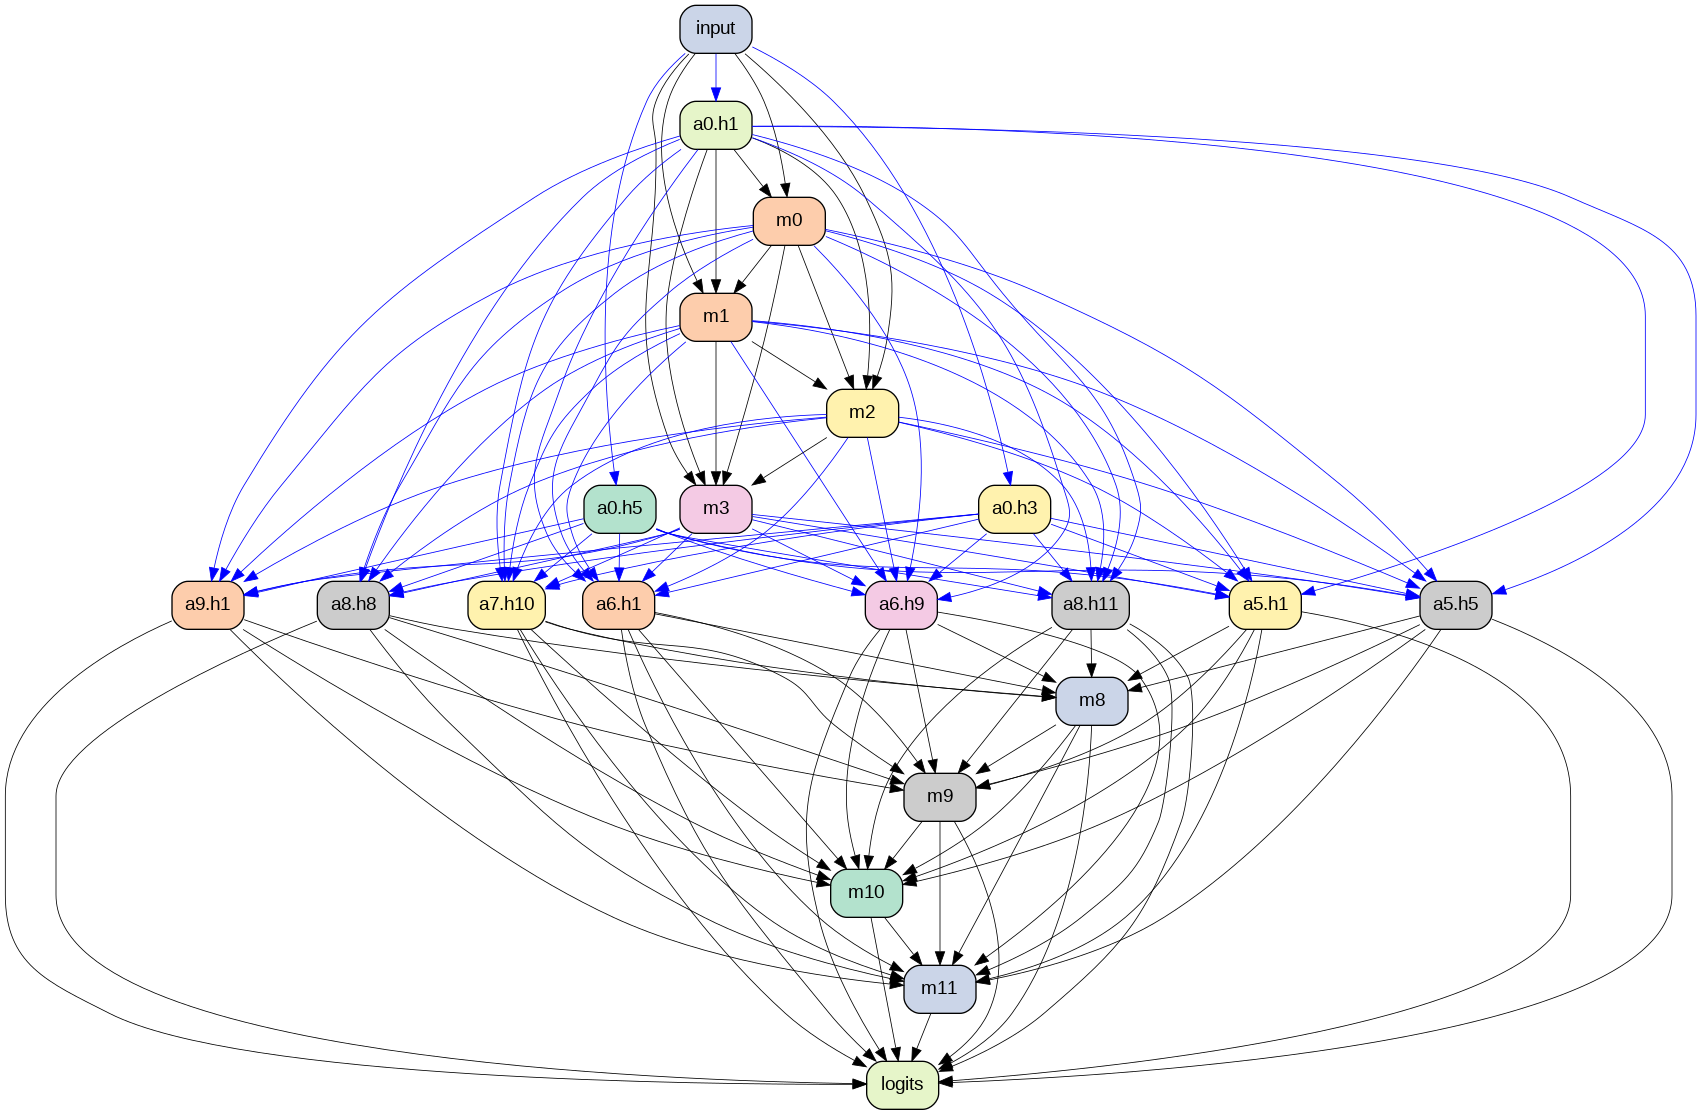

In [ ]:
for edge in g_manual.edges.values():
    if edge.score is None:
        edge.score = 0
gz_manual = g_manual.to_graphviz()
gz_manual.draw('graph_manual.png', prog='dot')
Image(filename='graph_manual.png')

# **EAP**

## **eap module**

In [17]:

def get_npos_input_lengths(model, inputs):
    tokenized = model.tokenizer(inputs, padding='longest', return_tensors='pt', add_special_tokens=True)
    n_pos = 1 + tokenized.attention_mask.size(1)
    input_lengths = 1 + tokenized.attention_mask.sum(1)
    return n_pos, input_lengths

def make_hooks_and_matrices(model: HookedTransformer, graph: Graph, batch_size:int , n_pos:int, scores):
    activation_difference = torch.zeros((batch_size, n_pos, graph.n_forward, model.cfg.d_model), device='cuda', dtype=model.cfg.dtype)

    processed_attn_layers = set()
    fwd_hooks_clean = []
    fwd_hooks_corrupted = []
    bwd_hooks = []

    def activation_hook(index, activations, hook, add:bool=True):
        acts = activations.detach()
        if not add:
            acts = -acts
        try:
            activation_difference[:, :, index] += acts
        except RuntimeError as e:
            print(hook.name, activation_difference[:, :, index].size(), acts.size())
            raise e

    def gradient_hook(fwd_index: Union[slice, int], bwd_index: Union[slice, int], gradients:torch.Tensor, hook):
        grads = gradients.detach()
        try:
            if isinstance(fwd_index, slice):
                fwd_index = fwd_index.start
            if grads.ndim == 3:
                grads = grads.unsqueeze(2)
            s = einsum(activation_difference[:, :, :fwd_index], grads,'batch pos forward hidden, batch pos backward hidden -> forward backward')
            s = s.squeeze(1)
            scores[:fwd_index, bwd_index] += s
        except RuntimeError as e:
            print(hook.name, activation_difference.size(), grads.size())
            raise e

    for name, node in graph.nodes.items():
        if isinstance(node, AttentionNode):
            if node.layer in processed_attn_layers:
                continue
            else:
                processed_attn_layers.add(node.layer)

        # exclude logits from forward
        fwd_index =  graph.forward_index(node)
        if not isinstance(node, LogitNode):
            fwd_hooks_corrupted.append((node.out_hook, partial(activation_hook, fwd_index)))
            fwd_hooks_clean.append((node.out_hook, partial(activation_hook, fwd_index, add=False)))
        if not isinstance(node, InputNode):
            if isinstance(node, AttentionNode):
                for i, letter in enumerate('qkv'):
                    bwd_index = graph.backward_index(node, qkv=letter)
                    bwd_hooks.append((node.qkv_inputs[i], partial(gradient_hook, fwd_index, bwd_index)))
            else:
                bwd_index = graph.backward_index(node)
                bwd_hooks.append((node.in_hook, partial(gradient_hook, fwd_index, bwd_index)))

    return (fwd_hooks_corrupted, fwd_hooks_clean, bwd_hooks), activation_difference

######                #######
#####  Edit from here  #######
#####                 #######

def get_scores(model: HookedTransformer, graph: Graph, dataset, metric: Callable[[Tensor], Tensor]):
    scores = torch.zeros((graph.n_forward, graph.n_backward), device='cuda', dtype=model.cfg.dtype)

    total_items = 0
    for clean, corrupted, target in tqdm(dataset):
        sens = [clean[0], corrupted[0]]
        sens = [str(s) for s in sens]
        max_length = max(len(model.tokenizer.tokenize(s)) for s in sens)
        padded_sentences = [model.tokenizer.encode(s, padding='max_length', max_length=max_length, return_tensors='pt', add_special_tokens=True) for s in sens]
        s1 = padded_sentences[0]
        s2 = padded_sentences[1]
        clean_dash = model.tokenizer.decode(s1[0])
        corrupted_dash = model.tokenizer.decode(s2[0])

        batch_size = len(clean_dash)
        total_items += batch_size
        n_pos, input_lengths = get_npos_input_lengths(model, clean_dash)

        (fwd_hooks_corrupted, fwd_hooks_clean, bwd_hooks), activation_difference = make_hooks_and_matrices(model, graph, batch_size, n_pos, scores)

        with model.hooks(fwd_hooks=fwd_hooks_corrupted):
            corrupted_logits = model(corrupted_dash)

        with model.hooks(fwd_hooks=fwd_hooks_clean, bwd_hooks=bwd_hooks):
            logits = model(clean_dash)
            label = torch.tensor(0, device='cpu', dtype=model.cfg.dtype)
            metric_value = metric(target,logits)
            metric_value.backward()

    scores /= total_items

    return scores

def get_scores_ig(model: HookedTransformer, graph: Graph, dataset, metric: Callable[[Tensor], Tensor], steps=30):
    scores = torch.zeros((graph.n_forward, graph.n_backward), device='cuda', dtype=model.cfg.dtype)

    total_items = 0
    for sentence, corrupted, target in tqdm(dataset):
        sens = [sentence, corrupted]
        sens = [str(s) for s in sens]
        max_length = max(len(model.tokenizer.tokenize(s)) for s in sens)
        padded_sentences = [model.tokenizer.encode(s, padding='max_length', max_length=max_length, return_tensors='pt', add_special_tokens=True) for s in sens]
        s1 = padded_sentences[0]
        s2 = padded_sentences[1]
        clean_dash = model.tokenizer.decode(s1[0])
        corrupted_dash = model.tokenizer.decode(s2[0])

        batch_size = len(clean_dash)
        total_items += batch_size
        n_pos, input_lengths = get_npos_input_lengths(model, clean_dash)

        (fwd_hooks_corrupted, fwd_hooks_clean, bwd_hooks), activation_difference = make_hooks_and_matrices(model, graph, batch_size, n_pos, scores)

        with torch.inference_mode():
            with model.hooks(fwd_hooks=fwd_hooks_corrupted):
                _ = model(corrupted_dash)

            input_activations_corrupted = activation_difference[:, :, graph.forward_index(graph.nodes['input'])].clone()

            with model.hooks(fwd_hooks=fwd_hooks_clean):
                clean_logits = model(clean_dash)

            input_activations_clean = input_activations_corrupted - activation_difference[:, :, graph.forward_index(graph.nodes['input'])]

        def input_interpolation_hook(k: int):
            def hook_fn(activations, hook):
                new_input = input_activations_clean + (k / steps) * (input_activations_corrupted - input_activations_clean)
                new_input.requires_grad = True
                return new_input
            return hook_fn

        total_steps = 0
        for step in range(1, steps+1):
            total_steps += 1
            with model.hooks(fwd_hooks=[(graph.nodes['input'].out_hook, input_interpolation_hook(step))], bwd_hooks=bwd_hooks):
                logits = model(clean_dash)
                label = torch.tensor(0, device='cpu', dtype=model.cfg.dtype)
                metric_value = metric(target,logits)
                metric_value.backward()

    scores /= total_items
    scores /= total_steps

    return scores

allowed_aggregations = {'sum', 'mean', 'l2'}

### Done upto here #########


def attribute(model: HookedTransformer, graph: Graph, dataset, metric: Callable[[Tensor], Tensor], aggregation='sum', integrated_gradients: Optional[int]=None):
    if aggregation not in allowed_aggregations:
        raise ValueError(f'aggregation must be in {allowed_aggregations}, but got {aggregation}')


    if integrated_gradients is None:
        scores = get_scores(model, graph, dataset, metric)
    else:
        assert integrated_gradients > 0, f"integrated_gradients gives positive # steps (m), but got {integrated_gradients}"
        scores = get_scores_ig(model, graph, dataset, metric, steps=integrated_gradients)

        if aggregation == 'mean':
            scores /= model.cfg.d_model
        elif aggregation == 'l2':
            scores = torch.linalg.vector_norm(scores, ord=2, dim=-1)

    scores = scores.cpu().numpy()

    for edge in tqdm(graph.edges.values(), total=len(graph.edges)):
        edge.score = scores[graph.forward_index(edge.parent, attn_slice=False), graph.backward_index(edge.child, qkv=edge.qkv, attn_slice=False)]

## **EAP and finding best scoring edges for positive Dataset**

In [18]:
attribute(model, g, dataset, partial(metric, loss=True, mean=True), integrated_gradients=30)

TypeError: 'module' object is not callable

In [ ]:
# include all edges whose absolute score is >= the 4th greatest absolute score
scores = g.scores(absolute=True)
# using a greedy search over the graph, starting from the logits, add in the highest-scoring edges (non-absolute)
#g.apply_greedy(2000)

In [ ]:
print(scores[-3:])

tensor([0.0009, 0.0011, 0.0012])


In [ ]:
# Checking the saturation in edge scores
No_of_top_scoring_edge = np.arange(0, 32491, 400)
least_score_saturated = []
for num in No_of_top_scoring_edge:
  least_score_saturated.append(scores[num])

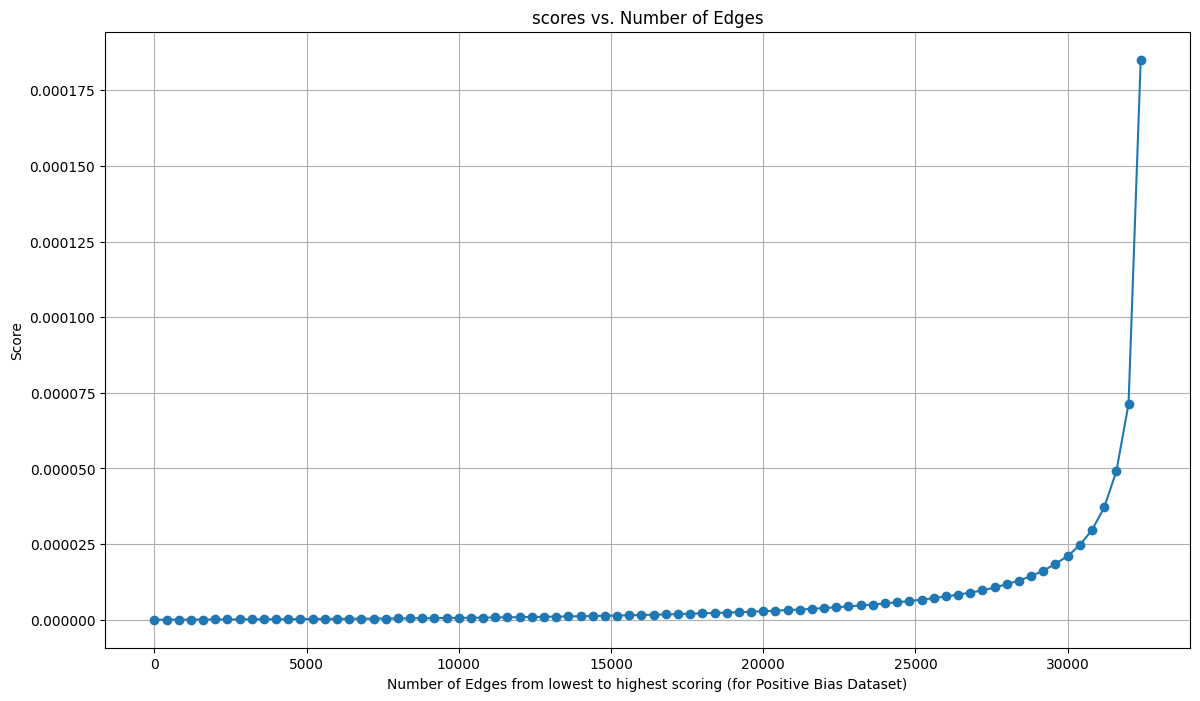

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(No_of_top_scoring_edge, least_score_saturated, marker='o')
plt.xlabel('Number of Edges from lowest to highest scoring (for Positive Bias Dataset)')
plt.ylabel('Score')
plt.title('scores vs. Number of Edges')
plt.grid(True)
plt.show()

In [ ]:
# Get the remaining edges as a list
remaining_edges = list(g.edges.items())

# Sort edges by their score (descending order)
remaining_edges.sort(key=lambda x: abs(x[1].score), reverse=True)

# Print the top 10 edges
for i, (edge_id, edge) in enumerate(remaining_edges[:3]):
    print(edge)
    print(f"  Score: {abs(edge.score)}")

Edge(m11->logits)
  Score: 0.0011550061171874404
Edge(input->m0)
  Score: 0.0011073092464357615
Edge(m0->m1)
  Score: 0.0008539618575014174


In [ ]:
# Ablating the top 10 edges in the graph and recording the evaluate graph scores(First we ablate top one edges, then top two edges and so on upto top 10 edges )
ablated_scores=[graph_baseline]
Edge_names = []
for i, (edge_id,edge) in enumerate(remaining_edges[:10]):
  Edge_names.append(str(edge_id))
for index, _ in enumerate(Edge_names):
  for i in range(index+1):
    g.edges[Edge_names[i]].in_graph=False

  ablated_scores.append(evaluate_graph(model,g,dataset,metric).mean())

  for j in range(index+1):
    g.edges[Edge_names[j]].in_graph=True


100%|██████████| 24/24 [00:03<00:00,  6.98it/s]


In [ ]:
ablated_scores_org = np.zeros(len(ablated_scores))
for i, score in enumerate(ablated_scores):
    ablated_scores_org[i] = score

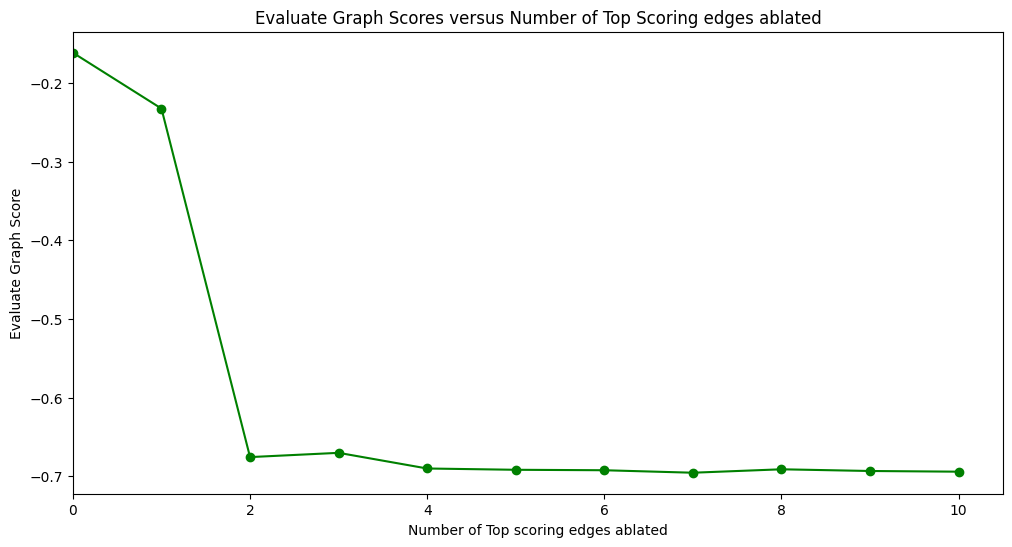

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(list(range(0,11)),ablated_scores_org,marker='o',color='green')
plt.xlabel('Number of Top scoring edges ablated')
plt.ylabel('Evaluate Graph Score')
plt.title('Evaluate Graph Scores versus Number of Top Scoring edges ablated')
plt.xlim(0)
plt.show()

here we observe that as we ablate more and more top scoring edges the evaluate graph score gets more and more negative. This is because the metric calculates summation of correct probs minus incorrect probs and as we ablated the top scoring edges the circuit loses its ability to predict correct output for the sequence and hence probabilities of incorrect next predicted tokens increases while as probabilities of correct next predicted tokens decreseas.

In [ ]:
# include all edges whose absolute score is >= the 500th greatest absolute score
g.apply_threshold(scores[-500], absolute=True)
g.apply_greedy(500)
g.prune_dead_nodes()

In [ ]:
print(f"The auto-circuit has {g.count_included_edges()} edges")

The auto-circuit has 460 edges


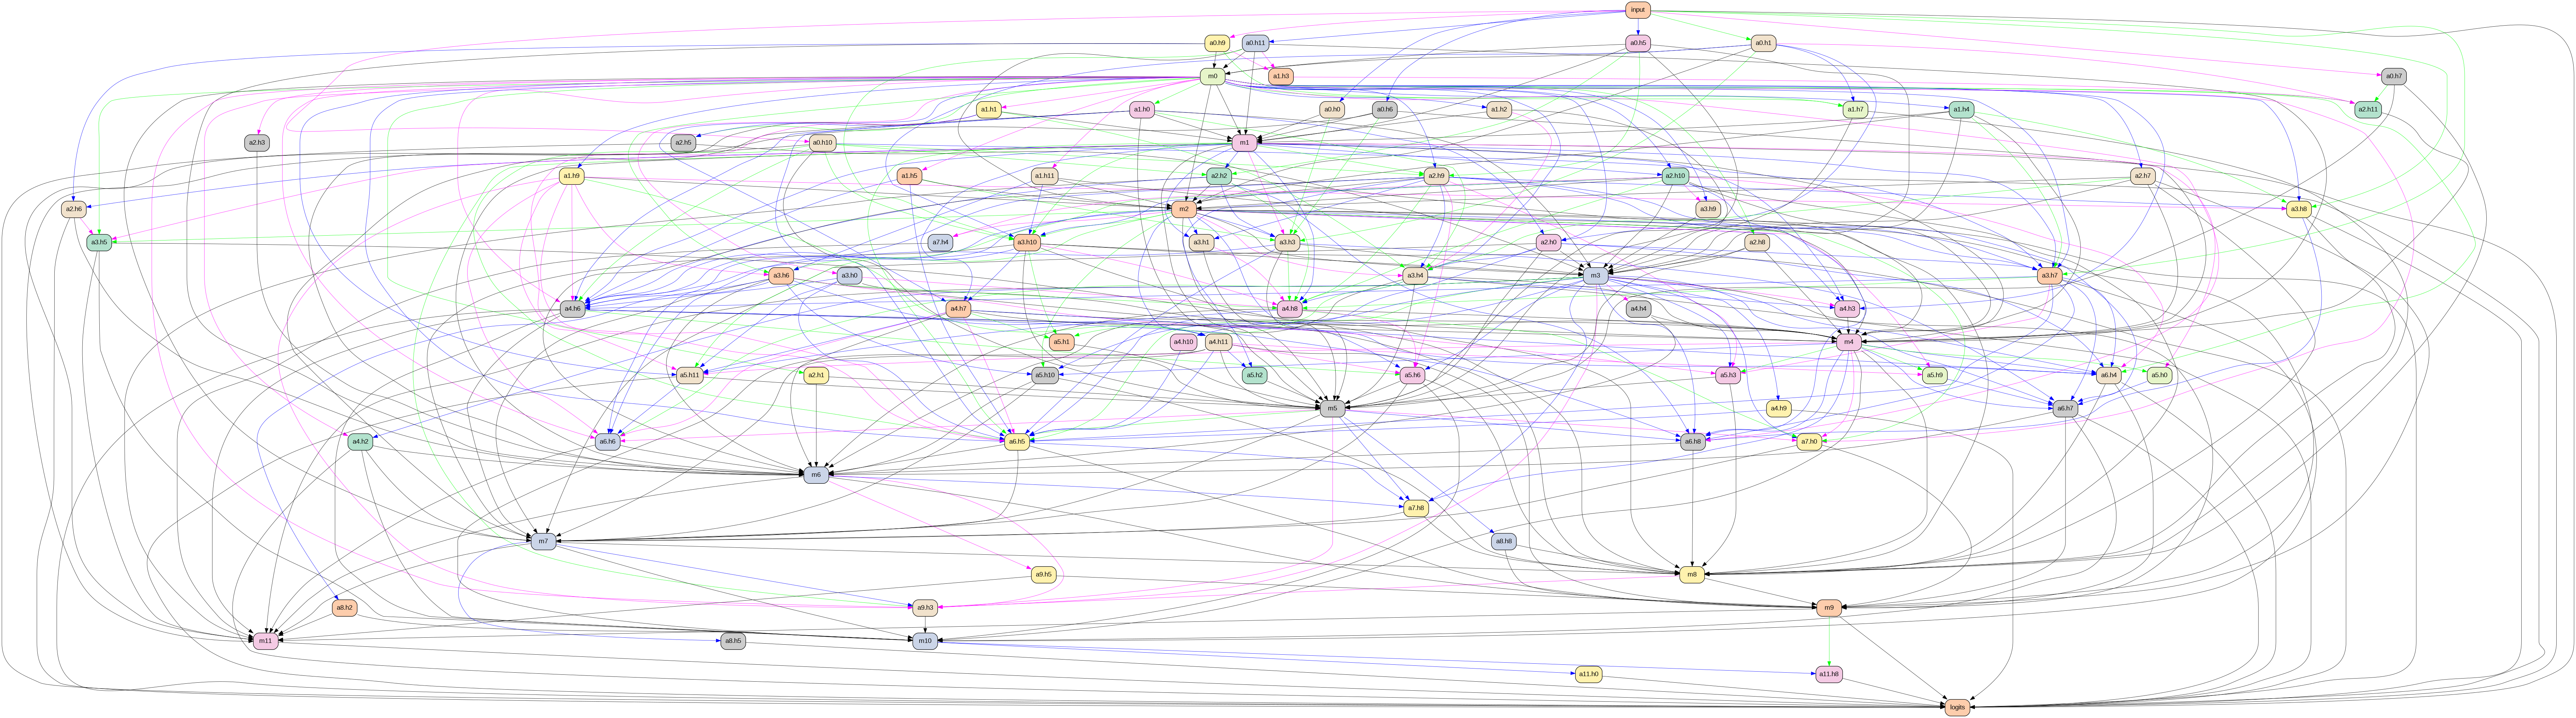

In [ ]:
gz = g.to_graphviz()
gz.draw('graph.png', prog='dot')
Image(filename='graph.png')

In [ ]:
g.to_json('graph.json')

In [ ]:
results = evaluate_graph(model, g, dataset, metric).mean()
print(f"\nGraph_baseline performance: {graph_baseline}, ablated_circuit performance: {results}")
print(f"The score difference between original and ablated circuits = {results - graph_baseline}")

100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Graph_baseline performance: -0.1611924022436142, ablated_circuit performance: -0.7203543186187744
The score difference between original and ablated circuits = -0.559161901473999


# **Visualizing Attention Heads**

 ## IOI Patching Setup
 This just copies the relevant set up from Exploratory Analysis Demo, and isn't very important.

In [73]:
prompts = [
    "When John and Mary went to the shops, John gave the bag to",
    "When John and Mary went to the shops, Mary gave the bag to",
    "When Tom and James went to the park, James gave the ball to",
    "When Tom and James went to the park, Tom gave the ball to",
    "When Dan and Sid went to the shops, Sid gave an apple to",
    "When Dan and Sid went to the shops, Dan gave an apple to",
    "After Martin and Amy went to the park, Amy gave a drink to",
    "After Martin and Amy went to the park, Martin gave a drink to",
]
answers = [
    (" Mary", " John"),
    (" John", " Mary"),
    (" Tom", " James"),
    (" James", " Tom"),
    (" Dan", " Sid"),
    (" Sid", " Dan"),
    (" Martin", " Amy"),
    (" Amy", " Martin"),
]

clean_tokens = model.to_tokens(prompts)
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i + 1 if i % 2 == 0 else i - 1) for i in range(len(clean_tokens))]
]
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))

answer_token_indices = torch.tensor(
    [
        [model.to_single_token(answers[i][j]) for j in range(2)]
        for i in range(len(answers))
    ],
    device=model.cfg.device,
)
print("Answer token indices", answer_token_indices)

Clean string 0 <|endoftext|>When John and Mary went to the shops, John gave the bag to
Corrupted string 0 <|endoftext|>When John and Mary went to the shops, Mary gave the bag to
Answer token indices tensor([[ 5335,  1757],
        [ 1757,  5335],
        [ 4186,  3700],
        [ 3700,  4186],
        [ 6035, 15686],
        [15686,  6035],
        [ 5780, 14235],
        [14235,  5780]], device='cuda:0')


In [18]:
df_dash = df.copy()
df_dash.drop(index=11, inplace=True)
df_dash.drop(index=13, inplace=True)
df_dash.drop(index=14, inplace=True)
df_dash.drop(index=16, inplace=True)
df_dash.drop(index=18, inplace=True)
df_dash.drop(index=19, inplace=True)
df_dash.drop(index=20, inplace=True)
df_dash.drop(index=21, inplace=True)
df_dash.drop(index=22, inplace=True)
df_dash.drop(index=23, inplace=True)
df_new=df_dash.reset_index(drop=True)
df_new.head(15)

clean                    corrupted    target  \
0                    1,2,3,4,                     1,1,1,1,         5   
1                    1 2 3 4                      1 1 1 1          5   
2                I,II,III,IV,                     I,I,I,I,         V   
3                10,20,30,40,                 10,10,10,10,        50   
4                   3,6,9,12,                     3,3,3,3,        15   
5                   3 6 9 12                      3 3 3 3         15   
6                I II III IV                      I I I I          V   
7                11,15,19,23,                 11,11,11,11,        27   
8                65,64,63,62,                 65,65,65,65,        61   
9                    A,B,C,D,                     A,A,A,A,         E   
10                   p,q,r,s,                     p,p,p,p,         t   
11  Monday,Tuesday,Wednesday,        Monday,Monday,Monday,  Thursday   
12                   5,4,3,2,                     5,5,5,5,         1   
13    Saturday,Sunday,Monday,  Saturday,Saturday,Saturday,   Tuesday   

   corr_target  
0            1  
1            1  
2            I  
3           10  
4            3  
5            3  
6            I  
7           11  
8           65  
9            A  
10           p  
11      Monday  
12           5  
13    Saturday

In [20]:
prompts = df_new['clean']
corrupted_prompts = df_new['corrupted']
answers = df_new['target']
corrupt_answers = df_new['corr_target']
clean_tokens = model.to_tokens(prompts)
corrupted_tokens = model.to_tokens(corrupted_prompts)
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))

answer_token_indices = torch.tensor(
    [
        [model.to_single_token(answers[i][0]), model.to_single_token(corrupt_answers[i][0])]
        for i in range(len(df_new))
    ],
    device=model.cfg.device,
)
print("Answer token indices", answer_token_indices)

Clean string 0 <|endoftext|>1,2,3,4,
Corrupted string 0 <|endoftext|>1,1,1,1,
Answer token indices tensor([[20, 16],
        [20, 16],
        [53, 40],
        [20, 16],
        [16, 18],
        [16, 18],
        [53, 40],
        [17, 16],
        [21, 21],
        [36, 32],
        [83, 79],
        [51, 44],
        [16, 20],
        [51, 50]])


In [21]:
def get_logit_diff(logits, answer_token_indices=answer_token_indices):
    if len(logits.shape) == 3:
        # Get final logits only
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()


clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean logit diff: 1.8471
Corrupted logit diff: -2.5821


In [22]:
CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff


def ioi_metric(logits, answer_token_indices=answer_token_indices):
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (
        CLEAN_BASELINE - CORRUPTED_BASELINE
    )


print(f"Clean Baseline is 1: {ioi_metric(clean_logits).item():.4f}")
print(f"Corrupted Baseline is 0: {ioi_metric(corrupted_logits).item():.4f}")

Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000


 ## Patching
 In the following cells, we define attribution patching and use it in various ways on the model.

In [23]:
Metric = Callable[[TT["batch_and_pos_dims", "d_model"]], float]

In [24]:
filter_not_qkv_input = lambda name: "_input" not in name


def get_cache_fwd_and_bwd(model, tokens, metric):
    model.reset_hooks()
    cache = {}

    def forward_cache_hook(act, hook):
        cache[hook.name] = act.detach()

    model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

    grad_cache = {}

    def backward_cache_hook(act, hook):
        grad_cache[hook.name] = act.detach()

    model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

    value = metric(model(tokens))
    value.backward()
    model.reset_hooks()
    return (
        value.item(),
        ActivationCache(cache, model),
        ActivationCache(grad_cache, model),
    )


clean_value, clean_cache, clean_grad_cache = get_cache_fwd_and_bwd(
    model, clean_tokens, ioi_metric
)
print("Clean Value:", clean_value)
print("Clean Activations Cached:", len(clean_cache))
print("Clean Gradients Cached:", len(clean_grad_cache))
corrupted_value, corrupted_cache, corrupted_grad_cache = get_cache_fwd_and_bwd(
    model, corrupted_tokens, ioi_metric
)
print("Corrupted Value:", corrupted_value)
print("Corrupted Activations Cached:", len(corrupted_cache))
print("Corrupted Gradients Cached:", len(corrupted_grad_cache))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



Clean Value: 1.0
Clean Activations Cached: 244
Clean Gradients Cached: 232
Corrupted Value: 0.0
Corrupted Activations Cached: 244
Corrupted Gradients Cached: 232


 ### Attention Attribution
 The easiest thing to start with is to not even engage with the corrupted tokens/patching, but to look at the attribution of the attention patterns - that is, the linear approximation to what happens if you set each element of the attention pattern to zero. This, as it turns out, is a good proxy to what is going on with each head!
 Note that this is *not* the same as what we will later do with patching. In particular, this does not set up a careful counterfactual! It's a good tool for what's generally going on in this problem, but does not control for eg stuff that systematically boosts John > Mary in general, stuff that says "I should activate the IOI circuit", etc. Though using logit diff as our metric *does*
 Each element of the batch is independent and the metric is an average logit diff, so we can analyse each batch element independently here. We'll look at the first one, and then at the average across the whole batch (note - 4 prompts have indirect object before subject, 4 prompts have it the other way round, making the average pattern harder to interpret - I plot it over the first sequence of tokens as a mildly misleading reference).
 We can compare it to the interpretability in the wild diagram, and basically instantly recover most of the circuit!

In [25]:
def create_attention_attr(
    clean_cache, clean_grad_cache
) -> TT["batch", "layer", "head_index", "dest", "src"]:
    attention_stack = torch.stack(
        [clean_cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    )
    attention_grad_stack = torch.stack(
        [clean_grad_cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    )
    attention_attr = attention_grad_stack * attention_stack
    attention_attr = einops.rearrange(
        attention_attr,
        "layer batch head_index dest src -> batch layer head_index dest src",
    )
    return attention_attr


attention_attr = create_attention_attr(clean_cache, clean_grad_cache)

In [26]:
HEAD_NAMES = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
HEAD_NAMES_SIGNED = [f"{name}{sign}" for name in HEAD_NAMES for sign in ["+", "-"]]
HEAD_NAMES_QKV = [
    f"{name}{act_name}" for name in HEAD_NAMES for act_name in ["Q", "K", "V"]
]
print(HEAD_NAMES[:5])
print(HEAD_NAMES_SIGNED[:5])
print(HEAD_NAMES_QKV[:5])

['L0H0', 'L0H1', 'L0H2', 'L0H3', 'L0H4']
['L0H0+', 'L0H0-', 'L0H1+', 'L0H1-', 'L0H2+']
['L0H0Q', 'L0H0K', 'L0H0V', 'L0H1Q', 'L0H1K']


 An extremely janky way to plot the attention attribution patterns. We scale them to be in [-1, 1], split each head into a positive and negative part (so all of it is in [0, 1]), and then plot the top 20 head-halves (a head can appear twice!) by the max value of the attribution pattern.

In [39]:
# Clone the repository
!git clone https://github.com/anthropics/PySvelte.git

# Change directory
%cd PySvelte


# Install dependencies
!pip install -r requirements.txt
!pip install .
import pysvelte


Cloning into 'PySvelte'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 44 (delta 8), reused 8 (delta 8), pack-reused 26 (from 1)
Receiving objects: 100% (44/44), 161.64 KiB | 1.74 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/PySvelte
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [40]:
def plot_attention_attr(attention_attr, tokens, top_k=20, index=0, title=""):
    if len(tokens.shape) == 2:
        tokens = tokens[index]
    if len(attention_attr.shape) == 5:
        attention_attr = attention_attr[index]
    attention_attr_pos = attention_attr.clamp(min=-1e-5)
    attention_attr_neg = -attention_attr.clamp(max=1e-5)
    attention_attr_signed = torch.stack([attention_attr_pos, attention_attr_neg], dim=0)
    attention_attr_signed = einops.rearrange(
        attention_attr_signed,
        "sign layer head_index dest src -> (layer head_index sign) dest src",
    )
    attention_attr_signed = attention_attr_signed / attention_attr_signed.max()
    attention_attr_indices = (
        attention_attr_signed.max(-1).values.max(-1).values.argsort(descending=True)
    )
    # print(attention_attr_indices.shape)
    # print(attention_attr_indices)
    attention_attr_signed = attention_attr_signed[attention_attr_indices, :, :]
    head_labels = [HEAD_NAMES_SIGNED[i.item()] for i in attention_attr_indices]

    if title:
        display(Markdown("### " + title))
    display(
        pysvelte.AttentionMulti(
            tokens=model.to_str_tokens(tokens),
            attention=attention_attr_signed.permute(1, 2, 0)[:, :, :top_k],
            head_labels=head_labels[:top_k],
        )
    )


plot_attention_attr(
    attention_attr,
    clean_tokens,
    index=0,
    title="Attention Attribution for first sequence",
)

plot_attention_attr(
    attention_attr.sum(0),
    clean_tokens[0],
    title="Summed Attention Attribution for all sequences",
)
print(
    "Note: Plotted over first sequence for reference, but pairs have IO and S1 in different positions."
)

### Attention Attribution for first sequence

pysvelte components appear to be unbuilt or stale
Running npm install...
Building pysvelte components with webpack...


### Summed Attention Attribution for all sequences

Note: Plotted over first sequence for reference, but pairs have IO and S1 in different positions.


 ## Attribution Patching
 In the following sections, I will implement various kinds of attribution patching, and then compare them to the activation patching patterns (activation patching code copied from [Exploratory Analysis Demo](https://neelnanda.io/exploratory-analysis-demo))
 ### Residual Stream Patching
 <details><summary>Note: We add up across both d_model and batch (Explanation).</summary>
 We add up along d_model because we're taking the dot product - the derivative *is* the linear map that locally linearly approximates the metric, and so we take the dot product of our change vector with the derivative vector. Equivalent, we look at the effect of changing each coordinate independently, and then combine them by adding it up - it's linear, so this totally works.
 We add up across batch because we're taking the average of the metric, so each individual batch element provides `1/batch_size` of the overall effect. Because each batch element is independent of the others and no information moves between activations for different inputs, the batched version is equivalent to doing attribution patching separately for each input, and then averaging - in this second version the metric per input is *not* divided by batch_size because we don't average.</details>

In [41]:
def attr_patch_residual(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
) -> TT["component", "pos"]:
    clean_residual, residual_labels = clean_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=True
    )
    corrupted_residual = corrupted_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=False
    )
    corrupted_grad_residual = corrupted_grad_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=False
    )
    residual_attr = einops.reduce(
        corrupted_grad_residual * (clean_residual - corrupted_residual),
        "component batch pos d_model -> component pos",
        "sum",
    )
    return residual_attr, residual_labels


residual_attr, residual_labels = attr_patch_residual(
    clean_cache, corrupted_cache, corrupted_grad_cache
)
imshow(
    residual_attr,
    y=residual_labels,
    yaxis="Component",
    xaxis="Position",
    title="Residual Attribution Patching",
)

# ### Layer Output Patching

In [42]:
def attr_patch_layer_out(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
) -> TT["component", "pos"]:
    clean_layer_out, labels = clean_cache.decompose_resid(-1, return_labels=True)
    corrupted_layer_out = corrupted_cache.decompose_resid(-1, return_labels=False)
    corrupted_grad_layer_out = corrupted_grad_cache.decompose_resid(
        -1, return_labels=False
    )
    layer_out_attr = einops.reduce(
        corrupted_grad_layer_out * (clean_layer_out - corrupted_layer_out),
        "component batch pos d_model -> component pos",
        "sum",
    )
    return layer_out_attr, labels


layer_out_attr, layer_out_labels = attr_patch_layer_out(
    clean_cache, corrupted_cache, corrupted_grad_cache
)
imshow(
    layer_out_attr,
    y=layer_out_labels,
    yaxis="Component",
    xaxis="Position",
    title="Layer Output Attribution Patching",
)

In [43]:
def attr_patch_head_out(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
) -> TT["component", "pos"]:
    labels = HEAD_NAMES

    clean_head_out = clean_cache.stack_head_results(-1, return_labels=False)
    corrupted_head_out = corrupted_cache.stack_head_results(-1, return_labels=False)
    corrupted_grad_head_out = corrupted_grad_cache.stack_head_results(
        -1, return_labels=False
    )
    head_out_attr = einops.reduce(
        corrupted_grad_head_out * (clean_head_out - corrupted_head_out),
        "component batch pos d_model -> component pos",
        "sum",
    )
    return head_out_attr, labels


head_out_attr, head_out_labels = attr_patch_head_out(
    clean_cache, corrupted_cache, corrupted_grad_cache
)
imshow(
    head_out_attr,
    y=head_out_labels,
    yaxis="Component",
    xaxis="Position",
    title="Head Output Attribution Patching",
)
sum_head_out_attr = einops.reduce(
    head_out_attr,
    "(layer head) pos -> layer head",
    "sum",
    layer=model.cfg.n_layers,
    head=model.cfg.n_heads,
)
imshow(
    sum_head_out_attr,
    yaxis="Layer",
    xaxis="Head Index",
    title="Head Output Attribution Patching Sum Over Pos",
)

 ### Head Activation Patching
 Intuitively, a head has three inputs, keys, queries and values. We can patch each of these individually to get a sense for where the important part of each head's input comes from!
 As a sanity check, we also do this for the mixed value. The result is a linear map of this (`z @ W_O == result`), so this is the same as patching the output of the head.
 We plot both the patch for each head over each position, and summed over position (it tends to be pretty sparse, so the latter is the same)

In [44]:
from typing_extensions import Literal


def stack_head_vector_from_cache(
    cache, activation_name: Literal["q", "k", "v", "z"]
) -> TT["layer_and_head_index", "batch", "pos", "d_head"]:
    """Stacks the head vectors from the cache from a specific activation (key, query, value or mixed_value (z)) into a single tensor."""
    stacked_head_vectors = torch.stack(
        [cache[activation_name, l] for l in range(model.cfg.n_layers)], dim=0
    )
    stacked_head_vectors = einops.rearrange(
        stacked_head_vectors,
        "layer batch pos head_index d_head -> (layer head_index) batch pos d_head",
    )
    return stacked_head_vectors


def attr_patch_head_vector(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    activation_name: Literal["q", "k", "v", "z"],
) -> TT["component", "pos"]:
    labels = HEAD_NAMES

    clean_head_vector = stack_head_vector_from_cache(clean_cache, activation_name)
    corrupted_head_vector = stack_head_vector_from_cache(
        corrupted_cache, activation_name
    )
    corrupted_grad_head_vector = stack_head_vector_from_cache(
        corrupted_grad_cache, activation_name
    )
    head_vector_attr = einops.reduce(
        corrupted_grad_head_vector * (clean_head_vector - corrupted_head_vector),
        "component batch pos d_head -> component pos",
        "sum",
    )
    return head_vector_attr, labels


head_vector_attr_dict = {}
for activation_name, activation_name_full in [
    ("k", "Key"),
    ("q", "Query"),
    ("v", "Value"),
    ("z", "Mixed Value"),
]:
    display(Markdown(f"#### {activation_name_full} Head Vector Attribution Patching"))
    head_vector_attr_dict[activation_name], head_vector_labels = attr_patch_head_vector(
        clean_cache, corrupted_cache, corrupted_grad_cache, activation_name
    )
    imshow(
        head_vector_attr_dict[activation_name],
        y=head_vector_labels,
        yaxis="Component",
        xaxis="Position",
        title=f"{activation_name_full} Attribution Patching",
    )
    sum_head_vector_attr = einops.reduce(
        head_vector_attr_dict[activation_name],
        "(layer head) pos -> layer head",
        "sum",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
    imshow(
        sum_head_vector_attr,
        yaxis="Layer",
        xaxis="Head Index",
        title=f"{activation_name_full} Attribution Patching Sum Over Pos",
    )

#### Key Head Vector Attribution Patching

#### Query Head Vector Attribution Patching

#### Value Head Vector Attribution Patching

#### Mixed Value Head Vector Attribution Patching

In [45]:
from typing_extensions import Literal


def stack_head_pattern_from_cache(
    cache,
) -> TT["layer_and_head_index", "batch", "dest_pos", "src_pos"]:
    """Stacks the head patterns from the cache into a single tensor."""
    stacked_head_pattern = torch.stack(
        [cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    )
    stacked_head_pattern = einops.rearrange(
        stacked_head_pattern,
        "layer batch head_index dest_pos src_pos -> (layer head_index) batch dest_pos src_pos",
    )
    return stacked_head_pattern


def attr_patch_head_pattern(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
) -> TT["component", "dest_pos", "src_pos"]:
    labels = HEAD_NAMES

    clean_head_pattern = stack_head_pattern_from_cache(clean_cache)
    corrupted_head_pattern = stack_head_pattern_from_cache(corrupted_cache)
    corrupted_grad_head_pattern = stack_head_pattern_from_cache(corrupted_grad_cache)
    head_pattern_attr = einops.reduce(
        corrupted_grad_head_pattern * (clean_head_pattern - corrupted_head_pattern),
        "component batch dest_pos src_pos -> component dest_pos src_pos",
        "sum",
    )
    return head_pattern_attr, labels


head_pattern_attr, labels = attr_patch_head_pattern(
    clean_cache, corrupted_cache, corrupted_grad_cache
)

plot_attention_attr(
    einops.rearrange(
        head_pattern_attr,
        "(layer head) dest src -> layer head dest src",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    ),
    clean_tokens,
    index=0,
    title="Head Pattern Attribution Patching",
)

### Head Pattern Attribution Patching

In [46]:
def get_head_vector_grad_input_from_grad_cache(
    grad_cache: ActivationCache, activation_name: Literal["q", "k", "v"], layer: int
) -> TT["batch", "pos", "head_index", "d_model"]:
    vector_grad = grad_cache[activation_name, layer]
    ln_scales = grad_cache["scale", layer, "ln1"]
    attn_layer_object = model.blocks[layer].attn
    if activation_name == "q":
        W = attn_layer_object.W_Q
    elif activation_name == "k":
        W = attn_layer_object.W_K
    elif activation_name == "v":
        W = attn_layer_object.W_V
    else:
        raise ValueError("Invalid activation name")

    return einsum(
        "batch pos head_index d_head, batch pos, head_index d_model d_head -> batch pos head_index d_model",
        vector_grad,
        ln_scales.squeeze(-1),
        W,
    )


def get_stacked_head_vector_grad_input(
    grad_cache, activation_name: Literal["q", "k", "v"]
) -> TT["layer", "batch", "pos", "head_index", "d_model"]:
    return torch.stack(
        [
            get_head_vector_grad_input_from_grad_cache(grad_cache, activation_name, l)
            for l in range(model.cfg.n_layers)
        ],
        dim=0,
    )


def get_full_vector_grad_input(
    grad_cache,
) -> TT["qkv", "layer", "batch", "pos", "head_index", "d_model"]:
    return torch.stack(
        [
            get_stacked_head_vector_grad_input(grad_cache, activation_name)
            for activation_name in ["q", "k", "v"]
        ],
        dim=0,
    )


def attr_patch_head_path(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
) -> TT["qkv", "dest_component", "src_component", "pos"]:
    """
    Computes the attribution patch along the path between each pair of heads.

    Sets this to zero for the path from any late head to any early head

    """
    start_labels = HEAD_NAMES
    end_labels = HEAD_NAMES_QKV
    full_vector_grad_input = get_full_vector_grad_input(corrupted_grad_cache)
    clean_head_result_stack = clean_cache.stack_head_results(-1)
    corrupted_head_result_stack = corrupted_cache.stack_head_results(-1)
    diff_head_result = einops.rearrange(
        clean_head_result_stack - corrupted_head_result_stack,
        "(layer head_index) batch pos d_model -> layer batch pos head_index d_model",
        layer=model.cfg.n_layers,
        head_index=model.cfg.n_heads,
    )
    path_attr = einsum(
        "qkv layer_end batch pos head_end d_model, layer_start batch pos head_start d_model -> qkv layer_end head_end layer_start head_start pos",
        full_vector_grad_input,
        diff_head_result,
    )
    correct_layer_order_mask = (
        torch.arange(model.cfg.n_layers)[None, :, None, None, None, None]
        > torch.arange(model.cfg.n_layers)[None, None, None, :, None, None]
    ).to(path_attr.device)
    zero = torch.zeros(1, device=path_attr.device)
    path_attr = torch.where(correct_layer_order_mask, path_attr, zero)

    path_attr = einops.rearrange(
        path_attr,
        "qkv layer_end head_end layer_start head_start pos -> (layer_end head_end qkv) (layer_start head_start) pos",
    )
    return path_attr, end_labels, start_labels


head_path_attr, end_labels, start_labels = attr_patch_head_path(
    clean_cache, corrupted_cache, corrupted_grad_cache
)
imshow(
    head_path_attr.sum(-1),
    y=end_labels,
    yaxis="Path End (Head Input)",
    x=start_labels,
    xaxis="Path Start (Head Output)",
    title="Head Path Attribution Patching",
)

ValueError: Einstein sum subscript 'bp' does not contain the correct number of indices for operand 1.

 This is hard to parse. Here's an experiment with filtering for the most important heads and showing their paths.

In [48]:
head_out_values, head_out_indices = head_out_attr.sum(-1).abs().sort(descending=True)
line(head_out_values)
top_head_indices = head_out_indices[:22].sort().values
top_end_indices = []
top_end_labels = []
top_start_indices = []
top_start_labels = []
for i in top_head_indices:
    i = i.item()
    top_start_indices.append(i)
    top_start_labels.append(start_labels[i])
    for j in range(3):
        top_end_indices.append(3 * i + j)
        top_end_labels.append(end_labels[3 * i + j])

imshow(
    head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1),
    y=top_end_labels,
    yaxis="Path End (Head Input)",
    x=top_start_labels,
    xaxis="Path Start (Head Output)",
    title="Head Path Attribution Patching (Filtered for Top Heads)",
)

NameError: name 'start_labels' is not defined

In [49]:
for j, composition_type in enumerate(["Query", "Key", "Value"]):
    imshow(
        head_path_attr[top_end_indices, :][:, top_start_indices][j::3].sum(-1),
        y=top_end_labels[j::3],
        yaxis="Path End (Head Input)",
        x=top_start_labels,
        xaxis="Path Start (Head Output)",
        title=f"Head Path to {composition_type} Attribution Patching (Filtered for Top Heads)",
    )

NameError: name 'head_path_attr' is not defined

In [ ]:
top_head_path_attr = einops.rearrange(
    head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1),
    "(head_end qkv) head_start -> qkv head_end head_start",
    qkv=3,
)
imshow(
    top_head_path_attr,
    y=[i[:-1] for i in top_end_labels[::3]],
    yaxis="Path End (Head Input)",
    x=top_start_labels,
    xaxis="Path Start (Head Output)",
    title=f"Head Path Attribution Patching (Filtered for Top Heads)",
    facet_col=0,
    facet_labels=["Query", "Key", "Value"],
)

 Let's now dive into 3 interesting heads: L5H5 (induction head), L8H6 (S-Inhibition Head), L9H9 (Name Mover) and look at their input and output paths (note - Q input means )

In [ ]:
interesting_heads = [
    5 * model.cfg.n_heads + 5,
    8 * model.cfg.n_heads + 6,
    9 * model.cfg.n_heads + 9,
]
interesting_head_labels = [HEAD_NAMES[i] for i in interesting_heads]
for head_index, label in zip(interesting_heads, interesting_head_labels):
    in_paths = head_path_attr[3 * head_index : 3 * head_index + 3].sum(-1)
    out_paths = head_path_attr[:, head_index].sum(-1)
    out_paths = einops.rearrange(out_paths, "(layer_head qkv) -> qkv layer_head", qkv=3)
    all_paths = torch.cat([in_paths, out_paths], dim=0)
    all_paths = einops.rearrange(
        all_paths,
        "path_type (layer head) -> path_type layer head",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
    imshow(
        all_paths,
        facet_col=0,
        facet_labels=[
            "Query (In)",
            "Key (In)",
            "Value (In)",
            "Query (Out)",
            "Key (Out)",
            "Value (Out)",
        ],
        title=f"Input and Output Paths for head {label}",
        yaxis="Layer",
        xaxis="Head",
    )

 ## Validating Attribution vs Activation Patching
 Let's now compare attribution and activation patching. Generally it's a decent approximation! The main place it fails is MLP0 and the residual stream
 My fuzzy intuition is that attribution patching works badly for "big" things which are poorly modelled as linear approximations, and works well for "small" things which are more like incremental changes. Anything involving replacing the embedding is a "big" thing, which includes residual streams, and in GPT-2 small MLP0 seems to be used as an "extended embedding" (where later layers use MLP0's output instead of the token embedding), so I also count it as big.
 See more discussion in the accompanying blog post!


 First do some refactoring to make attribution patching more generic. We make an attribution cache, which is an ActivationCache where each element is (clean_act - corrupted_act) * corrupted_grad, so that it's the per-element attribution for each activation. Thanks to linearity, we just compute things by adding stuff up along the relevant dimensions!

In [50]:
attribution_cache_dict = {}
for key in corrupted_grad_cache.cache_dict.keys():
    attribution_cache_dict[key] = corrupted_grad_cache.cache_dict[key] * (
        clean_cache.cache_dict[key] - corrupted_cache.cache_dict[key]
    )
attr_cache = ActivationCache(attribution_cache_dict, model)

 By block: For each head we patch the starting residual stream, attention output + MLP output

In [51]:
str_tokens = model.to_str_tokens(clean_tokens[0])
context_length = len(str_tokens)

In [52]:
every_block_act_patch_result = patching.get_act_patch_block_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)
imshow(
    every_block_act_patch_result,
    facet_col=0,
    facet_labels=["Residual Stream", "Attn Output", "MLP Output"],
    title="Activation Patching Per Block",
    xaxis="Position",
    yaxis="Layer",
    zmax=1,
    zmin=-1,
    x=[f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

In [53]:
def get_attr_patch_block_every(attr_cache):
    resid_pre_attr = einops.reduce(
        attr_cache.stack_activation("resid_pre"),
        "layer batch pos d_model -> layer pos",
        "sum",
    )
    attn_out_attr = einops.reduce(
        attr_cache.stack_activation("attn_out"),
        "layer batch pos d_model -> layer pos",
        "sum",
    )
    mlp_out_attr = einops.reduce(
        attr_cache.stack_activation("mlp_out"),
        "layer batch pos d_model -> layer pos",
        "sum",
    )

    every_block_attr_patch_result = torch.stack(
        [resid_pre_attr, attn_out_attr, mlp_out_attr], dim=0
    )
    return every_block_attr_patch_result


every_block_attr_patch_result = get_attr_patch_block_every(attr_cache)
imshow(
    every_block_attr_patch_result,
    facet_col=0,
    facet_labels=["Residual Stream", "Attn Output", "MLP Output"],
    title="Attribution Patching Per Block",
    xaxis="Position",
    yaxis="Layer",
    zmax=1,
    zmin=-1,
    x=[f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
)

In [54]:
scatter(
    y=every_block_attr_patch_result.reshape(3, -1),
    x=every_block_act_patch_result.reshape(3, -1),
    facet_col=0,
    facet_labels=["Residual Stream", "Attn Output", "MLP Output"],
    title="Attribution vs Activation Patching Per Block",
    xaxis="Activation Patch",
    yaxis="Attribution Patch",
    hover=[
        f"Layer {l}, Position {p}, |{str_tokens[p]}|"
        for l in range(model.cfg.n_layers)
        for p in range(context_length)
    ],
    color=einops.repeat(
        torch.arange(model.cfg.n_layers), "layer -> (layer pos)", pos=context_length
    ),
    color_continuous_scale="Portland",
)

 By head: For each head we patch the output, query, key, value or pattern. We do all positions at once so it's not super slow.

In [55]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)
imshow(
    every_head_all_pos_act_patch_result,
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Activation Patching Per Head (All Pos)",
    xaxis="Head",
    yaxis="Layer",
    zmax=1,
    zmin=-1,
)

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

In [60]:
def get_attr_patch_attn_head_all_pos_every(attr_cache):
    head_out_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("z"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_q_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("q"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_k_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("k"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_v_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("v"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_pattern_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("pattern"),
        "layer batch head_index dest_pos src_pos -> layer head_index",
        "sum",
    )

    return torch.stack(
        [
            head_out_all_pos_attr,
            head_q_all_pos_attr,
            head_k_all_pos_attr,
            head_v_all_pos_attr,
            head_pattern_all_pos_attr,
        ]
    )


every_head_all_pos_attr_patch_result = get_attr_patch_attn_head_all_pos_every(
    attr_cache
)
imshow(
    every_head_all_pos_attr_patch_result,
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Attribution Patching Per Head (All Pos)",
    xaxis="Head",
    yaxis="Layer",
    zmax=1,
    zmin=-1,
)

In [57]:
scatter(
    y=every_head_all_pos_attr_patch_result.reshape(5, -1),
    x=every_head_all_pos_act_patch_result.reshape(5, -1),
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Attribution vs Activation Patching Per Head (All Pos)",
    xaxis="Activation Patch",
    yaxis="Attribution Patch",
    include_diag=True,
    hover=head_out_labels,
    color=einops.repeat(
        torch.arange(model.cfg.n_layers),
        "layer -> (layer head)",
        head=model.cfg.n_heads,
    ),
    color_continuous_scale="Portland",
)

 We see pretty good results in general, but significant errors for heads L5H5 on query and moderate errors for head L10H7 on query and key, and moderate errors for head L11H10 on key. But each of these is fine for pattern and output. My guess is that the problem is that these have pretty saturated attention on a single token, and the linear approximation is thus not great on the attention calculation here, but I'm not sure. When we plot the attention patterns, we do see this!
 Note that the axis labels are for the *first* prompt's tokens, but each facet is a different prompt, so this is somewhat inaccurate. In particular, every odd facet has indirect object and subject in the opposite order (IO first). But otherwise everything lines up between the prompts

In [58]:
graph_tok_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))
]
imshow(
    clean_cache["pattern", 5][:, 5],
    x=graph_tok_labels,
    y=graph_tok_labels,
    facet_col=0,
    title="Attention for Head L5H5",
    facet_name="Prompt",
)
imshow(
    clean_cache["pattern", 10][:, 7],
    x=graph_tok_labels,
    y=graph_tok_labels,
    facet_col=0,
    title="Attention for Head L10H7",
    facet_name="Prompt",
)
imshow(
    clean_cache["pattern", 11][:, 10],
    x=graph_tok_labels,
    y=graph_tok_labels,
    facet_col=0,
    title="Attention for Head L11H10",
    facet_name="Prompt",
)


# [markdown]

In [59]:
every_head_by_pos_act_patch_result = patching.get_act_patch_attn_head_by_pos_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)
every_head_by_pos_act_patch_result = einops.rearrange(
    every_head_by_pos_act_patch_result,
    "act_type layer pos head -> act_type (layer head) pos",
)
imshow(
    every_head_by_pos_act_patch_result,
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Activation Patching Per Head (By Pos)",
    xaxis="Position",
    yaxis="Layer & Head",
    zmax=1,
    zmin=-1,
    x=[f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
    y=head_out_labels,
)

  0%|          | 0/1296 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def get_attr_patch_attn_head_by_pos_every(attr_cache):
    head_out_by_pos_attr = einops.reduce(
        attr_cache.stack_activation("z"),
        "layer batch pos head_index d_head -> layer pos head_index",
        "sum",
    )
    head_q_by_pos_attr = einops.reduce(
        attr_cache.stack_activation("q"),
        "layer batch pos head_index d_head -> layer pos head_index",
        "sum",
    )
    head_k_by_pos_attr = einops.reduce(
        attr_cache.stack_activation("k"),
        "layer batch pos head_index d_head -> layer pos head_index",
        "sum",
    )
    head_v_by_pos_attr = einops.reduce(
        attr_cache.stack_activation("v"),
        "layer batch pos head_index d_head -> layer pos head_index",
        "sum",
    )
    head_pattern_by_pos_attr = einops.reduce(
        attr_cache.stack_activation("pattern"),
        "layer batch head_index dest_pos src_pos -> layer dest_pos head_index",
        "sum",
    )

    return torch.stack(
        [
            head_out_by_pos_attr,
            head_q_by_pos_attr,
            head_k_by_pos_attr,
            head_v_by_pos_attr,
            head_pattern_by_pos_attr,
        ]
    )


every_head_by_pos_attr_patch_result = get_attr_patch_attn_head_by_pos_every(attr_cache)
every_head_by_pos_attr_patch_result = einops.rearrange(
    every_head_by_pos_attr_patch_result,
    "act_type layer pos head -> act_type (layer head) pos",
)
imshow(
    every_head_by_pos_attr_patch_result,
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Attribution Patching Per Head (By Pos)",
    xaxis="Position",
    yaxis="Layer & Head",
    zmax=1,
    zmin=-1,
    x=[f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
    y=head_out_labels,
)

In [ ]:
scatter(
    y=every_head_by_pos_attr_patch_result.reshape(5, -1),
    x=every_head_by_pos_act_patch_result.reshape(5, -1),
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Attribution vs Activation Patching Per Head (by Pos)",
    xaxis="Activation Patch",
    yaxis="Attribution Patch",
    include_diag=True,
    hover=[f"{label} {tok}" for label in head_out_labels for tok in graph_tok_labels],
    color=einops.repeat(
        torch.arange(model.cfg.n_layers),
        "layer -> (layer head pos)",
        head=model.cfg.n_heads,
        pos=15,
    ),
    color_continuous_scale="Portland",
)